# 秩和比法

- 优点1:TOPSIS 在实现上是所有评价方法中最简单的，它完全依赖于现有数据的分布情况，能对现有数据进行充分利用，但不适合处理模糊性指标(如我们只知道A好于B好于C)，而 RSR 法恰好弥补了TOPSIS 法的不足。此外，基于非参数的评价方法具有更好的抗异常值性，近几年也有不少医学论文将两者混合使用相互补充，在评价方法上这两种方法已经能够“闯荡江湖”了。还有另一种评价类问题——资源是否合理利用，往往使用DEA资料包络分析。
- 优点2:计算用的数值为秩次,可以消除异常值的干扰
- 优点3:融合参数分析方法,结果比单纯采用非参数法更精确,即可以直接排序又可以分档排序
- 缺点: 排序主要依据原始数据秩次,与原始数据的顺位间差距程度大小无关,指标转换为秩次会失去一些原始数据的信息

此处的"秩"并不是指矩阵中的秩,而是将$x_1,x_2,\cdots,x_n$从小到大排序后,$x_1$排到了$x(5)$的位置,其中5就是$x_1$在样本中的秩

- 样本秩:设$x_1,x_2,\cdots,x_n$是从一元总体抽取的容量为$n$的样本,其从小到大的顺序统计量为$x_{(1)},x_{(2)},\cdots,x_{(n)}$,若$x_i=x_{(k)}$,则称k是$x_i$在样本中的秩,即为$R_i$

- 秩和比法:是集古典参数估计和近代非参数统计各自优点与一体的统计方法,是数量方法中一种光谱的方法,针对性强,操作简便,使用效果明显.秩和比(RSR)指在多指标综合评价中,表中各评价对象n秩次的相对平均值,是一个非参数统计量,具有0-1区间连续变量的特征
- 基本思想:在一个n行(n评价对象)p列(p个评价指标)矩阵中,通过秩转换,获得无量纲的统计量RR,以RSR值对评价对象的优劣进行排序或分档排序
- 在综合评价中,秩和比的值能够包含所有评价指标的信息,显示出这些评价指标的综合水平,*RSR值越大表面综合评价越优*

基本思路
1. 列出原始数据表并编秩
2. 计算秩和比(RSR)或加权秩和比(WRSR)
3. 确定RSR的分布,列出分布表格情况,并计算概率单位Probit值
4. 计算直线回归方程
5. 分档排序

In [1]:
import numpy as np
import pandas as pd

## 编秩
编秩方法有整次秩和比法和非整次秩和比法.二者在计算秩的时候公式不一样.一般使用**整次秩和比法**

### 整次秩和比法
设有n个评价对象,m个评价指标的样本数据(n行m列),分别对每个指标列的数据编秩:正向指标(值越大越好)从小到大编秩,负向指标(值越小越好)从大到小编秩,当数据的值相同时编平均秩.得到秩矩阵$R=(R_{ij})_{n\times m}$
注:编秩即对数据排序,其顺序号为秩.这里的秩可以理解为是一种顺序或排序,它是根据原始数据的排序位置进行求解

In [2]:
df = pd.read_excel("秩和比法数据.xlsx",index_col=0)
df

,产前检查率,孕妇死亡率,围产儿死亡率
地区编码,,,
A,99.54,60.27,16.15
B,96.52,59.67,20.10
C,99.36,43.91,15.60
D,92.83,58.99,17.04
E,91.71,35.40,15.01
F,95.35,44.71,13.93
G,96.09,49.81,17.43
H,99.27,31.69,13.89
I,94.76,22.91,19.87


In [3]:
norm_list = [1, -1, -1] # 1 for postive, -1 for negative
# 使用熵权法确定权重
def min2max(data, col):
    return data.iloc[:, col].max() - data.iloc[:, col]
# 正向化指标
for i in range(len(norm_list)):
    if(norm_list[i]==-1):
        df.iloc[:,i] = min2max(df, i)
# 标准化
Z = df.apply(lambda x:x/np.sqrt(sum(x**2)))
if (df<0).sum().sum() <0 :
    Z = df.apply(lambda x:(x-x.min())/(x.max()-x.min()),axis=0)
P = Z/Z.sum()
e = np.nan_to_num(-P*np.log(P)).sum(axis=0)/np.log(len(P)) # 这里会出现空值，有一个概率为0，0*ln0由极限可知为0，但计算机求出来为0*-inf=nan
d = 1 - e
W = d/d.sum() # weight权重
pd.DataFrame(W,index=df.columns,columns=["熵权法确定的权重"])

f:\Anaconda\envs\tensorflow\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


,熵权法确定的权重
产前检查率,0.003165
孕妇死亡率,0.513471
围产儿死亡率,0.483364


In [4]:
# 此时的df是已经正向化后的数据
df_rank=pd.DataFrame()
for i, X in enumerate(df.columns):
    df_rank[f'X{str(i + 1)}:{X}'] = df.iloc[:, i]
    df_rank[f'R{str(i + 1)}:{X}'] = df.iloc[:, i].rank(method="dense")
df_rank

,X1:产前检查率,R1:产前检查率,X2:孕妇死亡率,R2:孕妇死亡率,X3:围产儿死亡率,R3:围产儿死亡率
地区编码,,,,,,
A,99.54,10.0,21.22,2.0,7.48,6.0
B,96.52,7.0,21.82,3.0,3.53,2.0
C,99.36,9.0,37.58,7.0,8.03,7.0
D,92.83,3.0,22.50,4.0,6.59,5.0
E,91.71,2.0,46.09,8.0,8.62,8.0
F,95.35,5.0,36.78,6.0,9.70,9.0
G,96.09,6.0,31.68,5.0,6.20,4.0
H,99.27,8.0,49.80,9.0,9.74,10.0
I,94.76,4.0,58.58,10.0,3.76,3.0


## 计算RSR,WRSE
在一个n行(n个评价对象)m列(m个评价指标)矩阵中,RSR的计算公式为:


$$RSR_i=\frac{1}{nm}\sum_{j=1}^{m}R_{ij}$$


上式中,$i=1,2,\cdots,n;j=1,2,\cdots,n$表示第i行第j列元素的秩

当评价指标的权重不同时,计算加权秩和比为WRSR,公式为:

$$WRSR_i=\frac{1}{n}\sum_{j=1}^{m}w_jR_{ij}$$


上式中,$w_j$为第$j$个指标的权重,且$\sum_{j=1}^mw_j=1$

In [5]:
# 利用熵权法得到的权重计算WRSR
m, n = df.shape
df_rank["WRSR"] = (df_rank.iloc[:,1::2]*W).sum(axis=1)/n # 如果只使用RSR,把这里的W去掉即可
df_rank["Rank"] = df_rank["WRSR"].rank(ascending=False,method="dense")
df_rank

,X1:产前检查率,R1:产前检查率,X2:孕妇死亡率,R2:孕妇死亡率,X3:围产儿死亡率,R3:围产儿死亡率,WRSR,Rank
地区编码,,,,,,,,
A,99.54,10.0,21.22,2.0,7.48,6.0,6.000000,4.0
B,96.52,7.0,21.82,3.0,3.53,2.0,4.000000,7.0
C,99.36,9.0,37.58,7.0,8.03,7.0,7.666667,2.0
D,92.83,3.0,22.50,4.0,6.59,5.0,4.000000,7.0
E,91.71,2.0,46.09,8.0,8.62,8.0,6.000000,4.0
F,95.35,5.0,36.78,6.0,9.70,9.0,6.666667,3.0
G,96.09,6.0,31.68,5.0,6.20,4.0,5.000000,6.0
H,99.27,8.0,49.80,9.0,9.74,10.0,9.000000,1.0
I,94.76,4.0,58.58,10.0,3.76,3.0,5.666667,5.0


## 计算概率单位Probit值
按照从小到大的顺序编制RSR或者WRSR频率分布表,列出各组频数$f_i$,计算各组累计频数$F_i$,计算累积频率$p_i=\frac{F_i}{n}$,最后一项用$(1-\frac{1}{4n})\times 100\%$修正.根据累积频率,查询"[百分数与概率单位对照表](https://www.docin.com/p-2211225521.html)",将$p_i$转换为概率单位Probit  
此表可用python的scipy求出

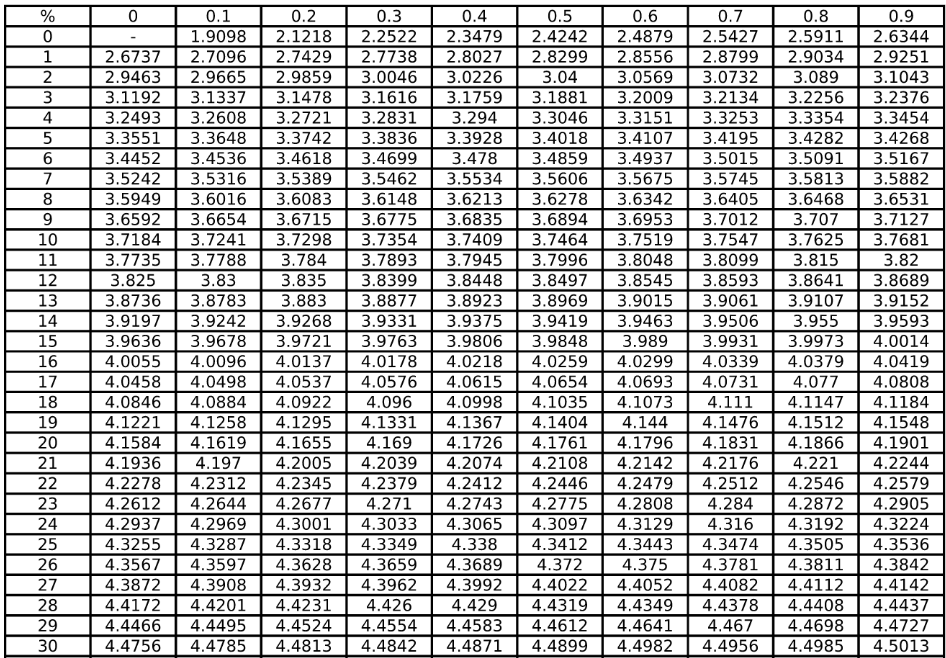

In [6]:
from scipy.stats import norm

WRSR = df_rank["WRSR"]
WRSR_rank_dict = dict(zip(WRSR.values,WRSR.rank().values)) # rank函数默认为平均秩数
distribution = pd.DataFrame(index = sorted(WRSR.unique()))
distribution["f"] = WRSR.value_counts().sort_index()
distribution["Σf"] = distribution["f"].cumsum()
distribution["average rank"] = [WRSR_rank_dict[i] for i in distribution.index]
distribution["average rank/n*100%"] = distribution["average rank"]/m
distribution.iloc[-1,-1] = 1 - 1/(4*n)
distribution['Probit'] = 5 - norm.isf(distribution.iloc[:, -1])
distribution

,f,Σf,average rank,average rank/n*100%,Probit
1.000000,1,1,1.0,0.100000,3.718448
4.000000,2,3,2.5,0.250000,4.325510
5.000000,1,4,4.0,0.400000,4.746653
5.666667,1,5,5.0,0.500000,5.000000
6.000000,2,7,6.5,0.650000,5.385320
6.666667,1,8,8.0,0.800000,5.841621
7.666667,1,9,9.0,0.900000,6.281552
9.000000,1,10,10.0,0.916667,6.382994


## 计算回归方程
以累积频率所对应的概率单位值Probit为自变量,以$RSR_i$或者$WRSR_i$值为因变量,计算回归方程:

$$RSR(WRSR)=a+b\times Probit$$

可用最小二乘法求出相应参数.  
注意:回归方程不一定要是线性的,可以选用二次回归方程甚至更高阶

In [7]:
import statsmodels.api as sm
r0 = np.polyfit(distribution['Probit'], distribution.index, deg=1) # 指定为1阶线性回归
pd.DataFrame(r0,index=["coefficient","bias"],columns=["value"])

,value
coefficient,2.489985
bias,-7.348473


In [8]:
if r0[1] > 0:
	print(f"\n回归直线方程为:y = {r0[0]} Probit + {r0[1]}")
else:
	print(f"\n回归直线方程为:y = {r0[0]} Probit - {abs(r0[1])}")


回归直线方程为:y = 2.48998450035445 Probit - 7.3484725483594655


In [9]:
sm.OLS(distribution.index, sm.add_constant(distribution['Probit'])).fit().summary()

f:\Anaconda\envs\tensorflow\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     87.43
Date:                Thu, 09 Feb 2023   Prob (F-statistic):           8.48e-05
Time:                        19:43:42   Log-Likelihood:                -6.9264
No. Observations:                   8   AIC:                             17.85
Df Residuals:                       6   BIC:                             18.01
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.3485      1.407     -5.222      0.002     -10.792      -3.905
Probit         2.4900      0.266      9.351      0.000       1.838       3.142
==============================================================================
Omnibus:                        2.852   Durbin-Watson:                   1.515
Prob(Omnibus):                  0.240   Jarque-Bera (JB):                0.982
Skew:                          -0.350   Prob(JB):                        0.612
Kurtosis:                       1.433   Cond. No.                         32.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

t 检验统计量较大，说明模型的回归系数具有统计学意义；拟合优度达到了90%以上，拟合效果较好，通过回归检验。

## 分档排序
分档排序亦可不做,直接按照回归方程重新计算WRSR估计值排序即可  
按照回归方程计算的RSR/WRSR估计值,对评价对象进行分档排序,分档数研究者根据实际情况决定.可为3档,4档,5档等  
以下等级越高越差

In [10]:
df_rank['Probit'] = df_rank['WRSR'].apply(lambda item: distribution.at[item, 'Probit'])
df_rank['WRSR Regression'] = np.polyval(r0, df_rank['Probit'])
threshold = np.polyval(r0, [2, 4, 6, 8])
grade = pd.DataFrame(pd.cut(df_rank['WRSR Regression'], threshold, labels=range(len(threshold) - 1, 0, -1)))
grade.columns = ["grade"]
grade

,grade
地区编码,
A,2
B,2
C,1
D,2
E,2
F,2
G,2
H,1
I,2


In [ ]:
# 0%-30%-40%-30%
# 